In [1]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init
from torch import nn
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from tqdm import tqdm_notebook
from tqdm import tqdm

# make nflib available
import sys
import os

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from nflib import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, 
    SlowMAF, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel, SS_Flow
)
from nflib.utils import (plot_model, ConstrainedGaussian, DatasetMoons, WeirdConstrainedGaussian, 
                           DatasetSIGGRAPH, DatasetMixture, ConstrainedGaussianInner)
from nflib.spline_flows import NSF_AR, NSF_CL
from rss_code_and_data.code.dmp import (DMP,gen_weights,imitate_path,plot_rollout)
# from robotic_constraints.main_vae_experiment_avoid import build_model
from robotic_constraints.main_experiment_avoid import build_model

from robotic_constraints.dataloader import NavigateFromTo
from robotic_constraints.utils import plot_trajectories
import torch.utils.data as data

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Load Trained Models

In [2]:
dim = 2
num_categories = 10
zeros = torch.zeros(dim)
ones = torch.eye(dim)

base = MultivariateNormal(zeros, ones)
means = torch.cat([base.sample((1,)) for s in range(num_categories)])
MultivariateNormal(means, ones).log_prob(zeros)

tensor([-2.5373, -3.3346, -1.8994, -4.9350, -1.8854, -5.0736, -2.1292, -7.7172,
        -2.2213, -1.8770])

In [3]:
from os import listdir
from os.path import isfile, join

device = torch.device("cpu")
exp_output = '../experiments/robotic_constraints/logs/'
output_files = [f for f in listdir(exp_output) if isfile(join(exp_output, f))]

print(len(output_files), output_files[0])

244 vae_256_True_0.01_0.9_60_100000.0_0.log


(0, 2000)

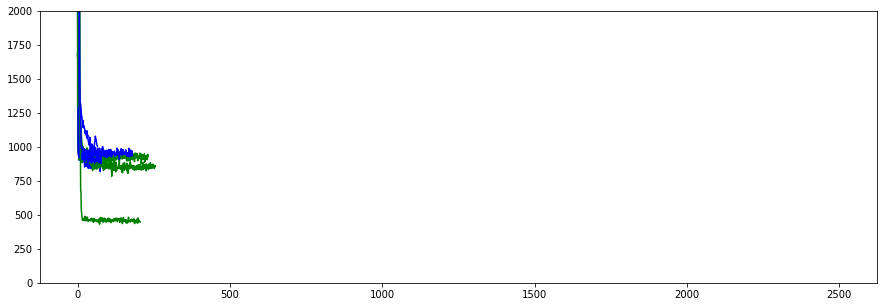

In [4]:
fig, axes = plt.subplots(1,1,figsize=(15,5))

scores = []
best = ""
best_score = np.inf

for f in output_files:
    
    columns = ['epoch', 'train_loss', 'valid_loss']
    log_df = pd.read_csv(join(exp_output, f), names=columns, skipfooter=1, engine='python').set_index('epoch')
    if "vae" not in f:
        continue
    if "True" in f:
#         axes.plot(log_df.train_loss, c='blue', label='train loss')
        axes.plot(log_df.valid_loss, c='blue', label='valid loss')
    else:
        axes.plot(log_df.valid_loss, c='green', label='valid loss')
#     if len(log_df.valid_loss[~log_df.valid_loss.isna()]) > 0:
    scores += [(f, log_df.valid_loss.min())]
#     if log_df.valid_loss.min() < best_score:
#         best_score = log_df.valid_loss[~log_df.valid_loss.isna()].min()
#         best = f

axes.set_ylim([0, 2000])

In [5]:
sorted([s for s in scores if not np.isnan(s[1])], key=lambda x: x[1])[:100]
# sorted(scores, key=lambda x: x[1])[:100]

[('vae_250_False_0.001_0.99_5_5000.0_0.log', 431.3151194254558),
 ('vae_250_False_0.001_0.99_40_1000.0_0.log', 783.7992197672527),
 ('vae_250_True_0.001_0.99_5_1000.0_0.log', 818.9881642659507),
 ('vae_250_True_0.001_0.99_1_5000.0_0.log', 842.7950490315757),
 ('vae_250_False_0.0001_0.99_10_10000.0_0.log', 862.3993581136067),
 ('vae_250_False_0.0001_0.99_10_1000.0_0.log', 873.9698791503906),
 ('vae_250_True_0.001_0.99_40_100.0_0.log', 876.0280100504558),
 ('vae_250_True_0.001_0.99_5_5000.0_0.log', 881.8117650349934),
 ('vae_250_True_0.0001_0.99_50_10000.0_0.log', 890.7317454020183),
 ('vae_250_True_0.001_0.99_40_1000.0_0.log', 904.5818481445312),
 ('vae_250_True_0.0001_0.99_10_1000.0_0.log', 906.6150817871094),
 ('vae_250_True_0.0001_0.99_50_100.0_0.log', 913.3309885660808),
 ('vae_250_False_0.001_0.99_40_5000.0_0.log', 9751.010416666666),
 ('vae_250_True_0.0001_0.99_10_10000.0_0.log', 10139.051310221354),
 ('vae_250_False_0.01_0.99_40_5000.0_0.log', 12211.691080729164),
 ('vae_250_Fals

# Load example data

In [24]:
input_dir = '../data/robotic_constraints/'
loader_params = {'batch_size': 128, 'shuffle': True, 'num_workers': 8}
training_set = NavigateFromTo(type='train', data_path=input_dir, trajectory=True)
trainloader = data.DataLoader(training_set, **loader_params)

validation_set = NavigateFromTo(type='validate', data_path=input_dir, trajectory=True)
validloader = data.DataLoader(validation_set, **loader_params)

test_set = NavigateFromTo(type='test', data_path=input_dir, trajectory=True)
testloader = data.DataLoader(test_set, **loader_params)

In [25]:
training_trajectories = []
weights_ = []
for j, (weights, condition_params, trajectory) in enumerate(trainloader):
    for i, traj in enumerate(weights):
        weights_.append(traj.view(-1,1))
    for i, traj in enumerate(trajectory):
        training_trajectories.append(traj.view(-1,2).detach().numpy())
        
        if i > 250:
            break
    if j > 6:
        break

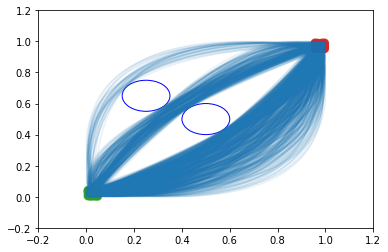

In [26]:
ax = plot_trajectories(training_trajectories, constraints=trainloader.dataset.constraints)
ax.set_ylim([-.2, 1.2])
ax.set_xlim([-.2, 1.2])
plt.show()

# Load the model

In [27]:
# change this to view the model with backward learning and that without
# best='vae_250_False_0.0001_0.99_20_5000.0_0.log'
# best = 'vae_250_True_0.001_0.99_40_5000.0_0.log'
# best = 'vae_250_False_0.001_0.99_40_1000.0_0.log'
# best = 'maf_250_False_0.001_0.99_10_0.log'
best = 'maf_250_False_0.001_0.99_10_0.log'

In [28]:
model_params = best.replace('.log', '')
# name, batch_size, backward, lr, gamma, hidden_dim, back_strength, seed = model_params.split("_")
name, batch_size, backward, lr, gamma, layers, seed = model_params.split("_")
# batch_size, backward, lr, gamma, layers, seed = model_params.split("_")
batch_size, backward, lr, gamma, layers, seed = (int(batch_size), 
                                                 eval(backward), 
                                                 float(lr), 
                                                 float(gamma), 
                                                 int(layers), 
                                                 int(seed),
#                                                 float(back_strength)
                                                                   )
batch_size, backward, lr, gamma, seed

(250, False, 0.001, 0.99, 0)

In [29]:
dims = training_set.n_dims
print(f'Building model with {dims} latent dims')
net = SS_Flow(flows=build_model(dim=dims, num_layers=layers, conditioning=False, num_conditioning=4),
                  NUM_CATEGORIES=5, dims=dims)
# net = build_model(data_dim=dims, hidden_dim=hidden_dim, conditioning=False, num_conditioning=4)
# net = build_model(dim=dims, num_layers=layers, conditioning=False, num_conditioning=4)

Building model with 20 latent dims


In [30]:
checkpoint = torch.load(os.path.join('../experiments/robotic_constraints/models/', 
                                     best.replace(".log", "") + '.best.pt'), map_location=torch.device('cpu'))
net.load_from_state_dict(checkpoint['net'])
# net.load_state_dict(checkpoint['net'])

True

In [43]:
# sample from the model
NUM_CATEGORIES = 5
num_samples = 1000

labels = torch.zeros(num_samples, NUM_CATEGORIES).to(device)
# labels[torch.arange(num_samples), torch.arange(NUM_CATEGORIES).repeat(num_samples//NUM_CATEGORIES)] = 1
labels[torch.arange(num_samples), 4*torch.ones(num_samples).long()] = 1

base = MultivariateNormal(torch.zeros(dims), torch.eye(dims))
z = base.sample((num_samples,))

condition_params = torch.tensor([np.random.uniform(0, .05,num_samples),
                                np.random.uniform(0,  .05,num_samples),
                                np.random.uniform(.95, 1.,num_samples),
                                np.random.uniform(.95, 1.,num_samples)]).float().T

condition_params_net, _= net.to_logits(condition_params)

# run the flow
# x_reconstructed = net.reconstruct(z)
# x_reconstructed, _ = net.backward(z)
# z = net.prior.sample(1000, labels)
xs, _ = net.backward(labels, condition_variable=condition_params_net)
# xs, _ = net.backward(z)
# x_reconstructed = xs[-1]
# net.sample(1000)
# x_reconstructed, _ = net(condition_params_net, condition_variable=condition_params_net)

In [44]:
# dist = MultivariateNormal(torch.zeros_like(x_reconstructed[0][0]), 
#                 torch.eye(len(x_reconstructed[0][0])))
# xs = x_reconstructed[0] + torch.exp(x_reconstructed[1]) * dist.sample((num_samples,))
    
# weights = x_reconstructed.view(num_samples, -1, dims//2)
weights = xs.view(num_samples, dims//2, -1).transpose(1,2)
# weights = xs.view(num_samples, -1, dims//2)
# weights.transpose_(1,2)
# weights = torch.cat(weights_, dim=1).T.view(-1,dims//2,2).transpose(1,2)

dmp = DMP(dims//2, dt=1/100, d=2, device=device)

# start = condition_params[:len(weights),:]
start = condition_params[:len(weights),:2]
goal = condition_params[:len(weights),-2:]

dmp.start = start
dmp.goal = goal
dmp.y0 = start
dmp.T = 100

y_track, dy_track, ddy_track = dmp.rollout_torch(start, goal, weights, device=device)

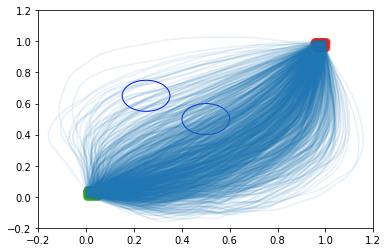

In [45]:
ax = plot_trajectories(y_track.detach().numpy(), constraints=trainloader.dataset.constraints)
ax.set_ylim([-.2, 1.2])
ax.set_xlim([-.2, 1.2])
# ax.set_ylim([-2, 2])
# ax.set_xlim([-2, 2])
plt.show()